**ReadMe**

An end to end RAG application
following are the components that are used to create this application.


*   **Retrieval**
      - OpenAI, huggingface* with *Pinecone* as vector database
*   **Generation**
      - Groq, Llama3
*   **Monitoring**
      - Langsmith
*   **Guardrails**
      - Nemo-guardrails
*   **Orchestration**
      - Langchain




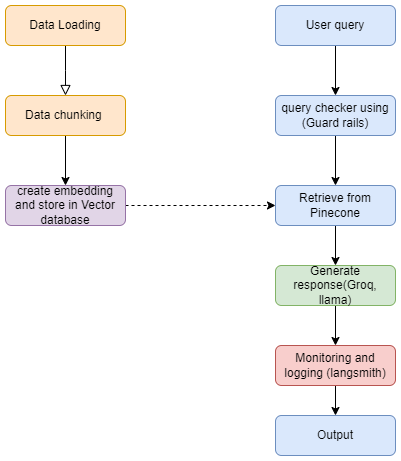



you also need to create a folder `config` and following files in it
1. `config.yml`
2. `prompts.yml`

files are added in the repository.
these files are used by guard rails to place some pre-requisite checks
over the input query.

Let's install a few requirements that we need to build the application.

In [1]:
!pip install beautifulsoup4 langchain langchain_community langchain_core langchain_groq langchain_openai langchain_pinecone langchain_text_splitters nemoguardrails pinecone python-dotenv streamlit nest_asyncio sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of nemoguardrails to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of nemoguardrails to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: Thi

In [1]:
import bs4
import os
import time
import asyncio
import nest_asyncio

In [2]:
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone, ServerlessSpec, PodSpec
from langchain_pinecone import PineconeVectorStore
from langchain import hub
from langchain_groq import ChatGroq
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from nemoguardrails import LLMRails, RailsConfig
from nemoguardrails.integrations.langchain.runnable_rails import RunnableRails
from pprint import pprint
from sentence_transformers import SentenceTransformer

In [3]:
test_flag = True

I used the google colab to create this pipeline. so its recommended to use cola b secrets to store the credentials.

we would be required to create account at


*   Pinecone
*   Groq
*   Langsmith
*   openai

you have to copy the api keys of all the above account to the secrets. the
api keys can be fetched using

```
from google.colab import userdata
secret = userdata.get('secret-key')
```

make sure to have api keys ready.


In [4]:
from google.colab import userdata
groq_key = userdata.get('groq-key')
smith_key = userdata.get('smith-key')
pine_key = userdata.get('pine-key')
openai_key = userdata.get('openai-key')

# if you want to use os env
# os.environ['groq_key'] = groq_key
# os.environ['smith_key'] = smith_key
# os.environ['pine_key'] = pine_key
# os.environ['openai_key'] = openai_key

In [5]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = smith_key
os.environ['LANGCHAIN_PROJECT'] = 'complete-rag'

In [6]:
model_llama = "llama3-70b-8192"
config_path = "./config"
chunksize = 2000
chunk_overlap = 100

Open-ai do not allows use of embedding model freely, you have to acquire the needed quotas to use them.

I have done a workaround by using the embedding model from hugging face and create a wrapper on top of that using `HuggingFaceEmbeddings` class

so install `transformers` as we going to to use that to get.

In [7]:
# another alternative, purposely keeping it commented
# !pip install sentence_transformers
# from sentence_transformers import SentenceTransformer
# embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [8]:
from transformers import AutoModel

embedding_model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
from langchain.embeddings import HuggingFaceEmbeddings # this is used to create embedding function however its not required when use openai api directly

In [10]:
embedding_function = HuggingFaceEmbeddings(model_name="jinaai/jina-embeddings-v2-base-en")

<ipython-input-10-8601a91dd662>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embedding_function = HuggingFaceEmbeddings(model_name="jinaai/jina-embeddings-v2-base-en")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
type(embedding_function)

langchain_community.embeddings.huggingface.HuggingFaceEmbeddings

one thing is important here, we may need to change the classes which we gave to SoupStrainer. you caan find that by doing the inspect and find the right class used in html page.

In [16]:
# run it separately to find the correct class use to parse the html page as per your chosen web url
if test_flag:
  web_url = "https://en.wikipedia.org/wiki/2022_FIFA_World_Cup"

  loader = WebBaseLoader(
        web_paths=(web_url,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header", "additional-class","mw-content-container")
            )
        ),
    )

  docs = loader.load()
docs

In [16]:
class RAG_PIPELINE:
  def __init__(
      self,
      web_url: str,
      model_llama: str,
      groq_key: str,
      pine_key: str,
      smith_key: str,
      config_path: str,
      openai_key: str = None,
      chunksize: int = 2000,
      chunk_overlap: int = 100
):
    """
    A RAG class for end to end application.
    """

    self.vectorstore_index_name = "complete-rag"
    self.loader = self.get_web_loader(web_url)

    # if you want to use openai, uncomment this, and proceed accordingly
    # self.embeddings = OpenAIEmbeddings(
    #         api_key=openai_key, model="<getit-from-openai>"
    #     )

    self.embeddings = embedding_function

    self.groq_llm = self.get_groq_llama(
                          model=model_llama,
                          groq_key=groq_key
    )
    self.text_splitter = self.get_text_splitter(chunksize, chunk_overlap)

    self.create_pinecone_index(self.vectorstore_index_name)

    self.vector_store = self.create_pinecone_vector_store(
                          self.vectorstore_index_name,
                          self.embeddings,
                          pine_key,
    )

    self.rag_prompt = hub.pull(
                        "rlm/rag-prompt",
                        api_key=smith_key
                        )

    config = RailsConfig.from_path(config_path)

    self.guardrails = RunnableRails(config=config,llm=self.groq_llm)


  def get_web_loader(self, web_url):
    """
    return an object of WebBaseLoader to parse the text from web url.
    """

    return WebBaseLoader(
        web_paths=(web_url,),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header", "mw-content-container")
            )
        ),
    )

  def get_groq_llama(self, model, groq_key):
    """
    return a Chatgroq instance to using the provided model and api key.
    """

    return ChatGroq(
        api_key=groq_key,
        model=model,
        temperature=0
    )

  def get_text_splitter(self, c_size: int, c_overlap: int):
    """
    return a text splitter object that can be used to split the text
    """

    return RecursiveCharacterTextSplitter(
        chunk_size=c_size,
        chunk_overlap=c_overlap
    )

  def create_pinecone_vector_store(self, idx_name: str, embedding_fn, pine_keys):
      """
      TO create a vectore store using Pinecone
      """

      return PineconeVectorStore(
        index_name=idx_name,
        embedding=embedding_fn,
        pinecone_api_key=pine_keys,
        #  text_key="text_field"
    )

  def create_pinecone_index(self, vectorstore_index_name):
    pc = Pinecone(api_key=pine_key)
    spec = ServerlessSpec(cloud="aws", region = "us-east-1")

    if vectorstore_index_name in pc.list_indexes().names():
      pc.delete_index(vectorstore_index_name)

    pc.create_index(
      vectorstore_index_name,
      dimension=768,  # you may need to vary the dimensions used in creating index in pinecone.
      metric='dotproduct',
      spec=spec
    )
    # wait for index to finish initialization
    while not pc.describe_index(vectorstore_index_name).status['ready']:
      time.sleep(1)

    print("passed: create_pinecone_index")

  def add_docs_in_vectorstore(self):
    docs = self.loader.load()
    split_docs = self.text_splitter.split_documents(docs)
    self.vector_store.add_documents(split_docs)

    print("passed: add_docs_in_vectorstore")

  def join_docs(Self, docs):
    pprint(docs)
    return "\n\n".join(doc.page_content for doc in docs)

  def create_retrieval_chain(self):
    """
    Load docs into the vector store, this has to be done one time.
    Create a rag chain.
    """

    """
    When using asynchronous programming in Python, an event loop is created to manage concurrent tasks.
    In LanChain's retriever and runnable through, these components might interact with different event loops, leading to conflicts and errors.
    The specific error message you encountered likely indicated a mismatch or incompatibility between the event loops involved.
    nest_asyncio Solves the Problem
    """

    nest_asyncio.apply()

    self.add_docs_in_vectorstore()
    self.retriever = self.vector_store.as_retriever()
    self.rag_chain = (
          {
              "context": self.retriever | self.join_docs,
              "question": RunnablePassthrough(),
          }
          | self.rag_prompt
          | self.groq_llm
          | StrOutputParser()
      )

    print("passed: create_retrieval_chain")
    self.rag_chain = self.guardrails | self.rag_chain
    print("passed: guardrails")


  def ask_question(self, query):
    """
    Ask your question.
    """

    nest_asyncio.apply()

    return self.rag_chain.invoke(query)

In [17]:
rag = RAG_PIPELINE(
    "https://en.wikipedia.org/wiki/2022_FIFA_World_Cup",
    model_llama,
    groq_key,
    pine_key,
    smith_key,
    config_path,
    openai_key,
    chunksize,
    chunk_overlap
)

passed: create_pinecone_index


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Lets create the vector store and an instance of rag chain

In [19]:
rag.create_retrieval_chain()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


passed: add_docs_in_vectorstore
passed: create_retrieval_chain
passed: guardrails


Lets start asking the questons.

In [20]:
output = rag.ask_question("When did fifa world cup 2022 happened")
output

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/2022_FIFA_World_Cup'}, page_content='People\nGianni Infantino\nAntonio Mateu Lahoz\nTamim bin Hamad Al Thani\nGrant Wahl\nSquads\nOfficials\n\n\nPromotional and related media\nAdidas Al Rihla\nFIFA 23 downloadable content\nMusic\nFIFA World Cup Qatar 2022 Official Soundtrack\n"Hayya Hayya (Better Together)"\n"Three Lions (It\'s Coming Home for Christmas)"\n"Tukoh Taka"\n"World Cup"'),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/2022_FIFA_World_Cup'}, page_content="1\xa0December\xa02022\xa0(2022-12-01)22:00\nCosta Rica\xa02–4\xa0Germany\n\nTejeda  58'\nVargas  70'\nReport\n\nGnabry  10'\nHavertz  73', 85'\nFüllkrug  89'\nAl Bayt Stadium, Al KhorAttendance: 67,054Referee: Stéphanie Frappart (France)\nGroup F\nMain article: 2022 FIFA World Cup Group F\nGroup F's first match was a goalless draw between Morocco and Croatia.[184] Canada had a penalty kick in the first half of their match against Belgium which was s

('The 2022 FIFA World Cup took place from November 23, 2022, to December 1, 2022.',
 True)

In [21]:
output = rag.ask_question("how many teams took part in it")
output

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/2022_FIFA_World_Cup'}, page_content="Category\n Commons\n\nvte Football in QatarQatar Football AssociationNational teams\nMen's\nU-23\nU-20\nU-17\nWomen's\nWorld Cup hosting\n1995 FIFA World Youth Championship\n2022 FIFA World Cup\nLeague competitions\nQatar Stars League\nQatari Second Division\nQatar Women's Football League (women)\nDomestic cup competitions\nEmir of Qatar Cup\nQatari Stars Cup\nQatar Cup\nQatari Super Cup\nQatar FA Cup \nQatari Second Division Cup\nInternational cup competitions\nAlkass International Cup\nInternational Friendship Tournament\nRivalries and derbies\nUnited Arab Emirates\nSaudi Arabia\nBahrain\nKuwait\nLists and categories\nClubs\nStadiums by capacity\nExpatriate managers\n\nMen's clubs\nMen's players\nExpatriate footballers\nManagers\nReferees\nVenues"),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/2022_FIFA_World_Cup'}, page_content='People\nGianni Infantino\nAntonio Mateu La

('The question is "how many teams took part in it". Unfortunately, the provided context does not explicitly mention the number of teams that participated in the 2022 FIFA World Cup.',
 True)